# Natural Language Processing

This chapter covers text analysis, also known as natural language processing. We'll cover tokenisation of text, removing stop words, counting words, performing other statistics on words, and analysing the parts of speech. The focus here is on English, but many of the methods-and even the libraries-are relevant to other languages too.

## Introduction

When doing NLP, it's worth thinking carefully about the unit of analysis: is it a corpus, a text, a line, a paragraph, a sentence, a word, or even a character? It could also be two of these simultaneously, and working with document x token matrices is one very common way of doing NLP. Although we'll be mixing between a few of these in this chapter, thinking about what the block of text data you're working with will really help you keep track of what operations are being deployed and how they might interact.

In case it's also useful to know, three of the most loved NLP packages are [**nltk**](https://www.nltk.org/), [**spaCy**](https://spacy.io/), and [**gensim**](https://radimrehurek.com/gensim/). As you progress through the chapter, you should also bear in mind that some of the methods we'll see are computationally expensive and you might want to fall back on simpler approaches, such as those seen in the previous chapter, if you have large volumes of text.

In this chapter, we'll use a single example and using NLP on it in a few different ways. First, though, we need to read in the text data we'll be using, part of Adam Smith's *The Wealth of Nations* and do some light cleaning of it.

Initially, we'll read in our text so that each new line appears on a different row of a **pandas** dataframe. We will end up working with it both as a vector of lines and, later, as a vector of lists of words. We'll also import the packages we'll need; remember, if you need these on your computer you may need to run `pip install packagename` on your own computer.

In [1]:
import pandas as pd
import string

In [2]:
df = pd.read_csv(
    "https://github.com/aeturrell/coding-for-economists/raw/main/data/smith_won.txt",
    delimiter="\n",
    names=["text"],
)
df.head()

,text
0,An Inquiry into the Nature and Causes of the...
1,"POWERS OF LABOUR, AND OF THE ORDER ACCORDING T..."
2,DISTRIBUTED AMONG THE DIFFERENT RANKS OF THE P...
3,DIVISION OF LABOUR. CHAPTER III. THAT THE ...
4,THE EXTENT OF THE MARKET. CHAPTER IV. OF T...


We need to do a bit of light text cleaning before we get on to the more in-depth natural language processing. We'll make use of vectorised string operations as seen in the [Introduction to Text](text-intro) chapter. First, we want to put everything in lower case:


In [3]:
df["text"] = df["text"].str.lower()
df.head()

,text
0,an inquiry into the nature and causes of the...
1,"powers of labour, and of the order according t..."
2,distributed among the different ranks of the p...
3,division of labour. chapter iii. that the ...
4,the extent of the market. chapter iv. of t...


Next, we'll remove the punctuation from the text. You may not always wish to do this but it's a good default.

In [4]:
translator = string.punctuation.maketrans({x: "" for x in string.punctuation})
df["text"] = df["text"].str.translate(translator)
df.head()

,text
0,an inquiry into the nature and causes of the...
1,powers of labour and of the order according to...
2,distributed among the different ranks of the p...
3,division of labour chapter iii that the di...
4,the extent of the market chapter iv of the...


Okay, we now have rows and rows of lower case words without punctuation.

```{admonition} Exercise
Remove all vowels from the vector of text using `str.translate`.
```

While we're doing some text cleaning, let's also remove the excess whitespace found in, for example, the first entry. Leaning on the cleaning methods from the previous chapter, we'll use regular expressions to do this:


In [5]:
df["text"] = df["text"].str.replace("\s+?\W+", " ", regex=True)

This searches for multiple whitespaces that preceede non-word characters and replaces them with a single whitespace.

## Tokenisation

We're going to now see an example of tokenisation: the process of taking blocks of text and breaking them down into tokens, most commonly a word but potentially all one and two word pairs. Note that you might sometimes see all two word pairs referred to as 2-grams, with an n-gram being all phrases of n words. There are many ways to tokenise text; we'll look at two of the most common: using regular expressions and using pre-configured NLP packages.

### Tokenisation with regular expressions

Because regular expressions excel at finding patterns in text, they can also be used to decide where to split text up into tokens. For a very simple example, let's take the first line of our text example:

In [6]:
import re

word_pattern = r"\w+"
tokens = re.findall(word_pattern, df.iloc[0, 0])
tokens

['an',
 'inquiry',
 'into',
 'the',
 'nature',
 'and',
 'causes',
 'of',
 'the',
 'wealth',
 'of',
 'nations',
 'by',
 'adam',
 'smith',
 'contents',
 'introduction',
 'and',
 'plan',
 'of',
 'the',
 'work',
 'book',
 'i',
 'of',
 'the',
 'causes',
 'of',
 'improvement',
 'in',
 'the',
 'productive']

This produced a split of a single line into one word tokens that are represented by a list of strings. We could have also asked for other variations, eg sentences, by asking to split at every ".". 


### Tokenisation using NLP tools

Many of the NLP packages available in Python come with built-in tokenisation tools. We'll use nltk for tokenisation.


In [7]:
from nltk.tokenize import word_tokenize

word_tokenize(df.iloc[0, 0])

['an',
 'inquiry',
 'into',
 'the',
 'nature',
 'and',
 'causes',
 'of',
 'the',
 'wealth',
 'of',
 'nations',
 'by',
 'adam',
 'smith',
 'contents',
 'introduction',
 'and',
 'plan',
 'of',
 'the',
 'work',
 'book',
 'i',
 'of',
 'the',
 'causes',
 'of',
 'improvement',
 'in',
 'the',
 'productive']

We have the same results as before when we used regex. Now let's scale this tokenisation up to our whole corpus while retaining the lines of text, giving us a structure of the form (lines x tokens):

In [8]:
df["tokens"] = df["text"].apply(lambda x: word_tokenize(x))
df.head()

,text,tokens
0,an inquiry into the nature and causes of the ...,"[an, inquiry, into, the, nature, and, causes, ..."
1,powers of labour and of the order according to...,"[powers, of, labour, and, of, the, order, acco..."
2,distributed among the different ranks of the p...,"[distributed, among, the, different, ranks, of..."
3,division of labour chapter iii that the divisi...,"[division, of, labour, chapter, iii, that, the..."
4,the extent of the market chapter iv of the ori...,"[the, extent, of, the, market, chapter, iv, of..."


**nltk** also has a `sent_tokenize` function that tokenises sentences, although as it makes use of punctuation you must take care with what pre-cleaning of text you undertake.


## Removing Stop Words

Stop words are frequent but uninformative words such as 'that', 'which', 'the', 'is', 'and', and 'but'. These words tend to be very common in the English language, but knowing that they appear frequently in a corpus doesn't really tell us much. Therefore, it is quite common to strip these 'stop' words out of text before doing any count-based analysis (or to use methods that implicitly ignore them). Many NLP libraries come with built-in methods that remove stop words. 

In this example of removing stop words, we'll use the [**nltk**](https://www.nltk.org/) library. We'll filter out any stopwords from the first entry in the tokens columns of our dataframe. Note that stop are often an add-on to a base library, and so are not always available from installing a package alone-one often needs to download the stop words relevant to whatever language you're working with.


In [9]:
import nltk

stopwords = nltk.corpus.stopwords.words(
    "english"
)  # Note that you may need to download these on your machine using nltk.download() within Python
words_filtered = [
    word.lower() for word in df.loc[0, "tokens"] if word.lower() not in stopwords
]
words_filtered

['inquiry',
 'nature',
 'causes',
 'wealth',
 'nations',
 'adam',
 'smith',
 'contents',
 'introduction',
 'plan',
 'work',
 'book',
 'causes',
 'improvement',
 'productive']

Having filtered the first entry, we can see that words such as 'an' and 'into' have disappeared but we have retained more informative words such as 'inquiry' and 'nature'. Processing one entry is not enough: we need all of the lines to have stopwords removed. So we can now scale this up to the full corpus with **pandas**. Just as we did above, we'll use a list comprehension to do this: but we'll vectorise the list comprehension across the whole "tokens" series of our dataframe.

In [10]:
df["tokens"] = df["tokens"].apply(
    lambda x: [word.lower() for word in x if word.lower() not in stopwords]
)
df.head()

,text,tokens
0,an inquiry into the nature and causes of the ...,"[inquiry, nature, causes, wealth, nations, ada..."
1,powers of labour and of the order according to...,"[powers, labour, order, according, produce, na..."
2,distributed among the different ranks of the p...,"[distributed, among, different, ranks, people,..."
3,division of labour chapter iii that the divisi...,"[division, labour, chapter, iii, division, lab..."
4,the extent of the market chapter iv of the ori...,"[extent, market, chapter, iv, origin, use, mon..."


Now we have a much reduced set of words in our tokens, which will make the next step of analysis more meaningful.

## Counting Text

There are several ways of performing basic counting statistics on text. We saw one in the previous chapter, `str.count()`, but that only applies to one word at a time. Often, we're interested in the relative counts of words in a corpus. In this section, we'll look at two powerful ways of computing this: using the `Counter` function and via term frequenc-inverse document frequency.

First, `Counter`, which is a built-in Python library that does pretty much what you'd expect. Here's a simple example:


In [11]:
from collections import Counter

fruit_list = [
    "apple",
    "apple",
    "orange",
    "satsuma",
    "banana",
    "orange",
    "mango",
    "satsuma",
    "orange",
]
freq = Counter(fruit_list)
freq

Counter({'apple': 2, 'orange': 3, 'satsuma': 2, 'banana': 1, 'mango': 1})

Counter returns a `collections.Counter` object where the numbers of each type in a given input list are summed. The resulting dictionnary of unique counts can be extracted using `dict(freq)`, and `Counter` has some other useful functions too including `most_common()` which, given a number `n`, returns `n` tuples of the form `(thing, count)`:

In [12]:
freq.most_common(10)

[('orange', 3), ('apple', 2), ('satsuma', 2), ('banana', 1), ('mango', 1)]

Say we wanted to apply this not just to every line in our corpus separately, but to our whole corpus in one go; how would we do it? `Counter` will happily accept a list but our dataframe token column is currently a vector of lists. So we must first transform the token column to a single list of all tokens and then apply `Counter`. To achieve the former and flatten a list of lists, we'll use `itertools` chain function which makes an iterator that returns elements from the first iterable until it is exhausted, then proceeds to the next iterable, until all of the iterables in all inputs are exhausted. For example, given `[a, b, c]` and `[d, e, f]` as arguments, this function would return `[a, b, c, d, e, f]`. Because this function accepts an arbitrary number of iterable arguments, we use the splat operator, aka `*`, to tell it to expect lots of different arguments. The second step using `Counter` is far more straightforward!

In [13]:
import itertools

merged_list = list(itertools.chain(*df["tokens"].to_list()))
freq = Counter(merged_list)
freq.most_common(10)

[('price', 775),
 ('labour', 578),
 ('quantity', 389),
 ('greater', 386),
 ('part', 376),
 ('silver', 355),
 ('one', 330),
 ('much', 323),
 ('upon', 322),
 ('may', 313)]

Looking at the tuples representing the 10 most words in the corpus, there are some interesting patterns. "price" and "labour" are hardly surprises, while "silver" perhaps reflects the time in which the book was written a little more. "one", "upon", and "may" are candidates for context-specific stopwords; while our NLTK stopwords might work well for modern text, they omit words that were once more common but that are equally uninformative to the stopwords we did use. There's no reason why these words couldn't be added to our list of stopwords and the process re-run.

```{admonition} Exercise
Extend the list of stopwords to include 'may', 'upon', 'one', and 'much', re-create the filtered tokens, and compute the 10 most common terms.
```

## Sentence Tokenisation (and reading in text as sentences)

So far we have been working with text that is split into lines and then tokenised into words. But working with lines of text is not always the most natural unit of analysis; sometimes sentences make more sense. So let's now work with sentences and see an example of tokenising those.

First, we need to read in the text as sentences. We can't do this with pandas, because that package is limited to tabular data or very simple delimiters (like commas).

If we were working with a local file on our computer, we could read it in using the following code

```python
with open('smith_won.txt') as f:
    raw_text = f.read()
```

As it is, the text file we'd like to grab is on the web so we'll use a package that can grab files from the internet to get hold of it.

In [14]:
import requests

response = requests.get(
    "https://github.com/aeturrell/coding-for-economists/raw/main/data/smith_won.txt"
)
raw_text = response.text
raw_text[:100]

'  An Inquiry into the Nature and Causes of the Wealth of Nations  by Adam Smith   Contents     INTRO'

Great, so we have our raw text. Let's now tokenise it using **nltk**.


In [15]:
from nltk.tokenize import sent_tokenize

sent_list = sent_tokenize(raw_text)
df_sent = pd.DataFrame({"text": sent_list})
df_sent.head()

,text
0,An Inquiry into the Nature and Causes of the...
1,BOOK I.
2,OF THE CAUSES OF IMPROVEMENT IN THE PRODUCTIVE...
3,CHAPTER I.
4,OF THE DIVISION OF LABOUR.


Now we just need to apply all of the cleaning procudures we did before——that is lowering the case, removing punctuation, and removing any excess whitespace.

In [16]:
df_sent["text"] = (
    df_sent["text"]
    .str.lower()
    .str.translate(translator)
    .str.replace("\s+?\W+", " ", regex=True)
)
df_sent.head()

,text
0,an inquiry into the nature and causes of the ...
1,book i
2,of the causes of improvement in the productive...
3,chapter i
4,of the division of labour


We'll use this tokenised version by sentence in the next section.

### TF-IDF

Term frequency - inverse document frequency, often referred to as *tf-idf*, is a measure of term counts (where terms could be 1-grams, 2-grams, etc.) that is weighted to try and identify the most *distinctively* frequent terms in a given corpus. It's made up of two parts: a term-frequency (which upweights according to counts of terms) and an inverse document frequency (which downweights terms that appear frequently across the corpus). Define $t$ as a term and $d$ as a document. In our example thus far, $t$ has represented words while our "documents" have been lines from *Wealth of Nations*. Then a simple formula for term frequency is:

$$
{\displaystyle \mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}}
$$

where $f_{t,d}$ represents the frequency of term $t$ in document $d$. To compute term frequencies, we will use the [**sklearn**](https://scikit-learn.org) package, which has a function called `CountVectorizer`.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(df["text"])
print(f"The shape of the resulting tf matrix is {np.shape(X)}")
vectorizer.get_feature_names()[500:510]

The shape of the resulting tf matrix is (7750, 5160)


['augustine',
 'aulnagers',
 'austria',
 'authentic',
 'authenticated',
 'author',
 'authorises',
 'authority',
 'authors',
 'avail']

This created a matrix of 5,160 terms by 7,750 "documents" (actually sentences in our example) running with more or less the default settings. The only change we made to those default settings was to pass in a list of stopwords that we used earlier. The other default settings tokenise words using a regex of "(?u)\b\w\w+\b", assume text is lowercase, only accept n-grams in the range (1, 1), and have no limit on the maximum number of features.

The matrix X that comes out is of an interesting type:

In [18]:
type(X)

scipy.sparse.csr.csr_matrix

ie, it's a *sparse matrix*. Sparse matrices are more efficient for your computer when there are many missing zeros in a matrix. They do all of the usual things that matrices (arrays) do, but are just more convenient in this case. Most notably, we can perform counts with them and we can turn them into a regular matrix using `.toarray()`.

Let's do some basic stats using the matrix of counts and the **matplotlib** visualisation library.

In [19]:
counts_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names()).T
counts_df = counts_df.sum(axis=1)
counts_df = counts_df.sort_values(ascending=False)
counts_df.head()

price       775
labour      578
quantity    389
greater     386
part        376
dtype: int64

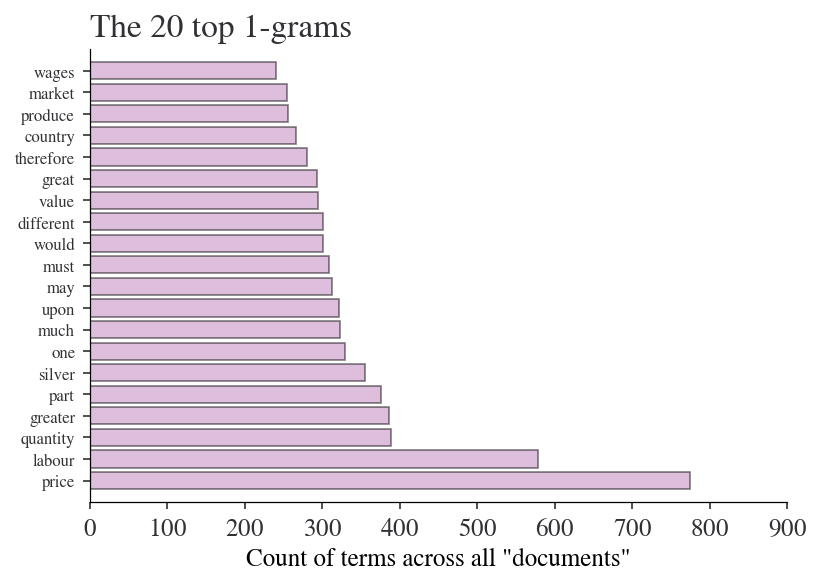

In [20]:
import matplotlib.pyplot as plt

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)


num_to_plot = 20
x_pos = np.arange(num_to_plot)
fig, ax = plt.subplots()
ax.barh(x_pos, counts_df[:num_to_plot], align="center", alpha=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(counts_df[:num_to_plot].index, fontsize=8)
ax.set_ylim(-1, num_to_plot)
ax.set_xlabel('Count of terms across all "documents"')
ax.set_title(f"The {num_to_plot} top 1-grams")
plt.show()

Let's see what happens when we ask only for bi-grams.

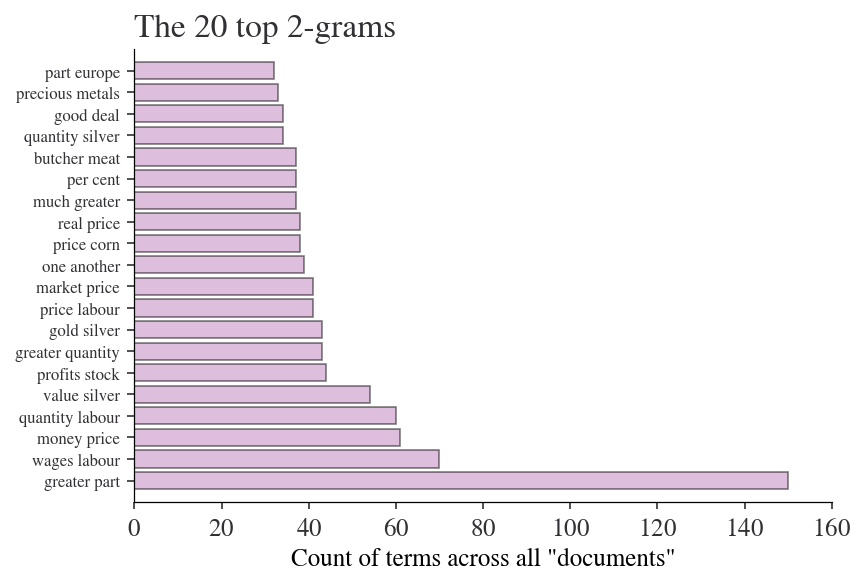

In [21]:
# Count bigrams:
vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2, 2), max_features=300)
bigrams_df = (
    pd.DataFrame(
        vectorizer.fit_transform(df["text"]).toarray(),
        columns=vectorizer.get_feature_names(),
    )
    .T.sum(axis=1)
    .sort_values(ascending=False)
)

# Plot top n 2-grams
num_to_plot = 20
x_pos = np.arange(num_to_plot)
fig, ax = plt.subplots()
ax.barh(x_pos, bigrams_df[:num_to_plot], align="center", alpha=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(bigrams_df[:num_to_plot].index, fontsize=8)
ax.set_ylim(-1, num_to_plot)
ax.set_xlabel('Count of terms across all "documents"')
ax.set_title(f"The {num_to_plot} top 2-grams")
plt.show()

As you might expect, the highest frequency with which 2-grams occur is less than the highest frequency with which 1-grams occur.

Now let's move on to the inverse document frequency. The most common definition is 

$$
\mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}
$$

where $D$ is the set of documents, $N=|D|$, and  $|\{d \in D: t \in d\}|$ is the number of documents in which $t$ appears. Putting both together we have

$$
\mathrm{tfidf}(t, d, D) = \mathrm{tf}(t, d) \cdot \mathrm{idf}(t, D)
$$

Because of power-law scaling, problems with zero-count entries, and other issues, this basic formula is often modified and the [wikipedia page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for tf-idf gives a good run-down of some common options.

To perform tfidf with code, we'll use another **sklearn** function, `TfidfVectorizer`.

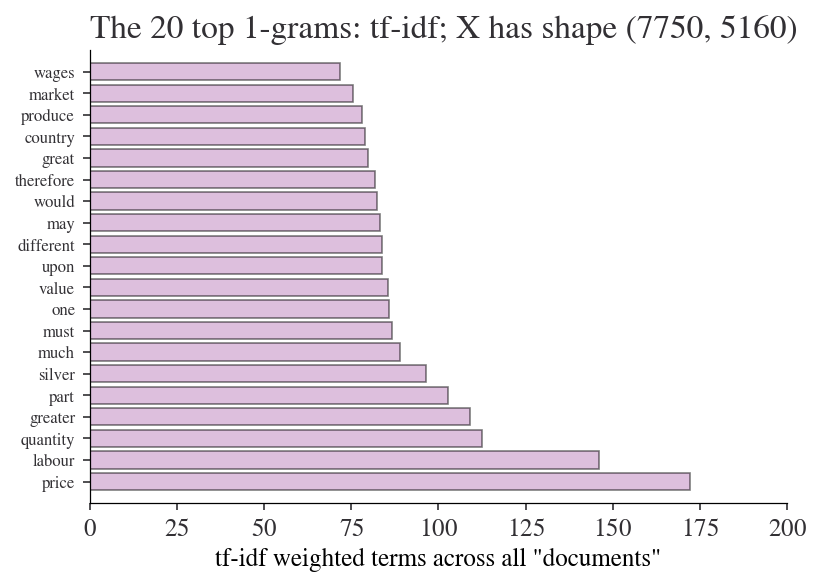

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, sublinear_tf=True)
X = tfidf_vectorizer.fit_transform(df["text"])
counts_tfidf = (
    pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
    .T.sum(axis=1)
    .sort_values(ascending=False)
)
# Plot top n 1-grams
num_to_plot = 20
x_pos = np.arange(num_to_plot)
fig, ax = plt.subplots()
ax.barh(x_pos, counts_tfidf[:num_to_plot], align="center", alpha=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(counts_tfidf[:num_to_plot].index, fontsize=8)
ax.set_ylim(-1, num_to_plot)
ax.set_xlabel('tf-idf weighted terms across all "documents"')
ax.set_title(f"The {num_to_plot} top 1-grams: tf-idf; X has shape {np.shape(X)}")
plt.show()

There are small differences between this ranking of terms versus the original tf 1-gram version above. In the previous one, words such as 'one' were slightly higher in the ranking but their common appearance in multiple documents (lines) downweights them here. In this case, we also used the sublinear option, which uses $1+\log(\mathrm{tf})$ in place of $\mathrm{tf}$.

#### Vector Inner Product and Cosine Similarity

Because the output of tf or tf-idf is a matrix, many possibilities related to linear algebra are opened up. In particular, we can think of this the creation of a tf-idf matrix as definining a $|t| = T$ dimensional vector space that is spanned by the term vectors (which act like basis vectors). Each document in the corpus then has a vector representation in terms of the basis vectors. A consequence is that there is a sensible inner vector product defined on the space. As a demonstration, let's look for the line in the book that is closest to the title according to this vector space. The vector for the first line is just the first row in $X$. We take the argmax of the inner product with all of the *other* line vectors to find the entry in `X` that maximises the inner product.

In [23]:
max_val = np.argmax(np.dot(X[0, :], X[1:, :].T))
print(max_val)

102


In [24]:
print(
    f"Cosine similarity is {round(np.dot(X[0], X[max_val+1].T).toarray().flatten()[0], 2)}"
)
for i, sent in enumerate(df.iloc[[0, max_val + 1], 0]):
    print(f"Sentence {i}:")
    print("\t" + sent.strip() + "\n")

Cosine similarity is 0.42
Sentence 0:
	an inquiry into the nature and causes of the wealth of nations by adam smith contents introduction and plan of the work book i of the causes of improvement in the productive

Sentence 1:
	the society book i of the causes of improvement in the



We can see from this example *why* the sentence we found is the most similar in the book to the title: it contains a phrase that is very similar to part of the title. It's worth noting here that tf-idf (and tf) do not care about *word order*, they only care about frequency, and so sometimes the most similar sentences are not what you would expect if you were judging similarity based on concepts. Another way of saying this is that the concept of 'similarity' as used by tf-idf is limited.

#### Transform versus Fit Transform

The `fit_transform` function we've seen is actually performing two operations here: i) create a vector space from the basis defined by terms from the text and ii) express each document (here, a sentence) as a vector in this vector space. But there's no reason why these two operations have to be linked. In fact, by separating out these two operations, we can do nifty things like express one text in the basis vectors of another. This is more useful in practice than you might think. It allows you to ask questions like, "which of the texts in my reference corpus is most closest to these other texts?", and more. We would ask this question by taking the inner vector product of the matrices expressing the two corpora, and find the rows of Wealth of Nations that have the greatest cosine similarity with the other texts.

Let's see an example, with some test texts.

In [25]:
df_test = pd.DataFrame(
    {
        "text": [
            "poverty is a trap and rearing children in it is hard and perilous",
            "people in different trades can meet and develop a conspiracy which ultimately hurts consumers by raising prices",
        ]
    }
)

Now we need to i) create the vector space, ii) express WoN in the vector space, iii) express the test texts in the vector space, iv) find which rows of the WoN match best the test texts, and v) print out those rows.



In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, sublinear_tf=True)
# i)
model = tfidf_vectorizer.fit(df_sent["text"])
# ii)
X = tfidf_vectorizer.transform(df_sent["text"])
# iii)
Y = tfidf_vectorizer.transform(df_test["text"])
# iv)
max_index_pos = np.argmax(X * Y.T, 0).tolist()[0]
max_index_pos

[1012, 1768]

Now, armed with the rows of $X$, we are ready for the final part, v)

In [27]:
for y_pos, x_pos in enumerate(max_index_pos):
    print(f"Sentence number {y_pos}:")
    print(f'        test: {df_test.loc[y_pos, "text"]}')
    print(f'         WoN: {df_sent.loc[x_pos, "text"]} \n')

Sentence number 0:
        test: poverty is a trap and rearing children in it is hard and perilous
         WoN: but poverty though it does not prevent the generation is extremely unfavourable to the rearing of children 

Sentence number 1:
        test: people in different trades can meet and develop a conspiracy which ultimately hurts consumers by raising prices
         WoN: people of the same trade seldom meet together even for merriment and diversion but the conversation ends in a conspiracy against the public or in some contrivance to raise prices 



#### Using a Special Vocabulary

But why should the basis vectors come from the terms in another text? Couldn't they come from anywhere? The answer is, of course, yes. We could choose any set of basis vectors we liked to define our vector space, and express a text in it. For this, we need a *special vocabulary*.

Let's see an example of expressing the Wealth of Nations in a particularly vocab. First, we must define our vocab:

In [28]:
vocab = ["work", "wage", "labour", "real price", "money price", "productivity"]

That done, we now plug our special vocab into `CountVectorizer` to tell it to ignore anything that isn't relevant (isn't in our vocab).

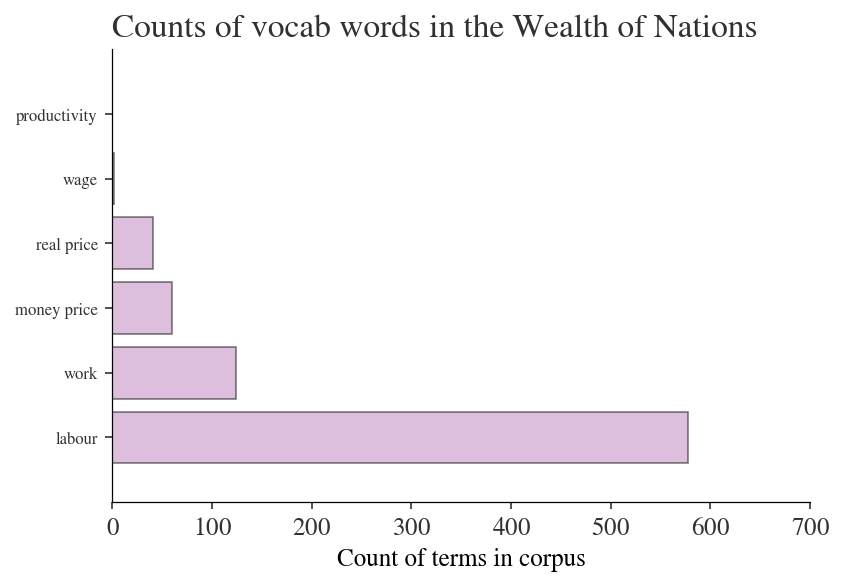

In [29]:
vectorizer = CountVectorizer(vocabulary=vocab, ngram_range=(1, 2))
counts_df = (
    pd.DataFrame(
        vectorizer.fit_transform(df_sent["text"]).toarray(),
        columns=vectorizer.get_feature_names(),
    )
    .T.sum(axis=1)
    .sort_values(ascending=False)
)

# Plot counts from our vocab
num_to_plot = len(vocab)
x_pos = np.arange(num_to_plot)
fig, ax = plt.subplots()
ax.barh(x_pos, counts_df[:num_to_plot], align="center", alpha=0.5)
ax.set_yticks(x_pos)
ax.set_yticklabels(counts_df[:num_to_plot].index, fontsize=8)
ax.set_ylim(-1, num_to_plot)
ax.set_xlabel("Count of terms in corpus")
ax.set_title(f"Counts of vocab words in the Wealth of Nations")
plt.show()

Note that we did not pass `stopwords` in this case; there's no need, because passing a `vocab` effectively says to categorise any word that is *not* in the special vocabulary as a stopword. We also still passed an n-gram range to ensure our longest n-gram, with $n=2$, was counted.

### Filtering Out Frequent and Infrequent Words

As well as passing stopwords in, defining vocabularies, and limiting the n-gram range, there's another couple of ways to cut down on the number of terms that tf-idf takes account of. The first is to use the `max_features` setting to limit how many terms are tracked (this only keeps the top terms). A second is to have frequency cut-offs, both for very frequent words and for very infrequent words (be careful of this one if you're doing any kind of out-of-sample exercise such as forecasting.) The keywords for frequency cut-offs are `max_df` and `min_df`.

## Context of Terms

It's all very well counting terms, but without the context of the surrounding words, it may not be all that informative. **nltk** has some functions that can help us. First, we have to pass our raw text into an **nltk** text object.



In [30]:
from nltk.text import Text

w_o_n = Text(word_tokenize(raw_text))

Now let's imagine we're interested in the context of a particular term, say 'price'. We can run:

In [31]:
w_o_n.concordance("price")

Displaying 25 of 775 matches:
. CHAPTER V. OF THE REAL AND NOMINAL PRICE OF COMMODITIES , OR OF THEIR PRICE I
L PRICE OF COMMODITIES , OR OF THEIR PRICE IN LABOUR , AND THEIR PRICE IN MONEY
OF THEIR PRICE IN LABOUR , AND THEIR PRICE IN MONEY . CHAPTER VI . OF THE COMPO
ER VI . OF THE COMPONENT PART OF THE PRICE OF COMMODITIES . CHAPTER VII . OF TH
PTER VII . OF THE NATURAL AND MARKET PRICE OF COMMODITIES . CHAPTER VIII . OF T
 in most years nearly about the same price with the corn of England , though , 
at comes to the same thing , for the price of a great quantity of theirs . He s
one to the other , except such whose price was very considerable in proportion 
value ; or wherein consists the real price of all commodities . Secondly , what
e different parts of which this real price is composed or made up . And , lastl
e or all of these different parts of price above , and sometimes sink them belo
es which sometimes hinder the market price , that is , the actual price of comm
 market pr

This gives us context for all fo the occurrences of the terms. Context is useful, but there's more than one kind. What about *where* in a text references to different ideas or terms appear? We can do that with  *text dispersion plot*, as shown below for a selection of terms.

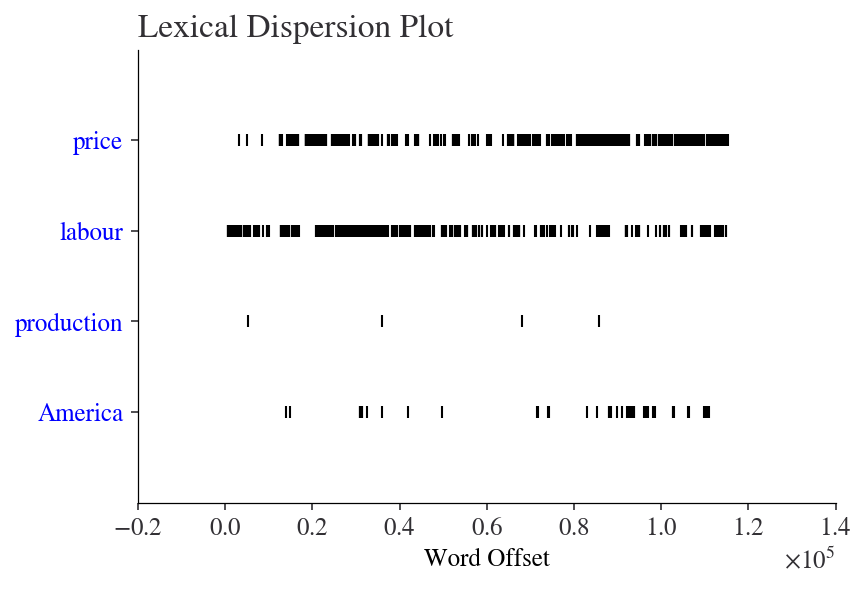

In [32]:
w_o_n.dispersion_plot(["price", "labour", "production", "America"])

## Stemming and Lemmatisation

You may have wondered, in these examples, what about words that mean the same but have different endings, for example "work", "working",  "worked", and "works"? In most of the examples shown, we've only counted one of these words and thereby could *underestimate* their prescence. If what we really want to do is capture all discussion of a topic like 'work',  we should really be counting every variation on the word representing that topic.

*Stemming* is a way to do this because it takes the stem of all of these words, in this example "work", and then counts the stems. It's true that this is sometimes a bit more nonsensical than using the original word (think "sci" for "science", "scientist", and "scientific") but it can give a more accurate take on the occurrence of a term.


**nltk** includes more than one stemmer to reduce words to their roots. Let's see what happens when we take the tokenised words and stem them.

In [33]:
from nltk import LancasterStemmer

# create an object of class LancasterStemmer
lancaster = LancasterStemmer()

cleaner_text = raw_text.translate(translator).lower()

stem_tokens = [
    lancaster.stem(term.lower())
    for term in word_tokenize(cleaner_text)
    if term.lower() not in stopwords
]
stem_tokens[120:135]

['iv',
 'stock',
 'lent',
 'interest',
 'chapt',
 'v',
 'diff',
 'employ',
 'capit',
 'book',
 'ii',
 'diff',
 'progress',
 'op',
 'diff']

Now we have "pric" instead of price, and "compon" instead of "compnonent", and so on. The stemming has taken away the ends of the words, leaving us with just their stem. Let's see if a word count following this approach will be different.

In [34]:
freq = Counter(stem_tokens)
freq.most_common(10)

[('pric', 832),
 ('gre', 700),
 ('labo', 686),
 ('part', 511),
 ('quant', 442),
 ('country', 388),
 ('produc', 356),
 ('silv', 355),
 ('diff', 348),
 ('on', 348)]

In this case, the words that are most frequent are much the same: but you can imagine this could easily have *not* been the case and, if you're interested in fully capturing a topic, it's a good idea to at least check a stemmed version for comparison.

*Lemmatisation* is slightly different; it's a bit more intelligent than just chopping off the end of the word because it considers context and converts a word to a base form, called a lemma. Let's perform the same exercise using lemmatisation.

In [35]:
from nltk import WordNetLemmatizer

# create an object of class LancasterStemmer
wnet_lemma = WordNetLemmatizer()

lemma_tokens = [
    wnet_lemma.lemmatize(term.lower())
    for term in word_tokenize(cleaner_text)
    if term.lower() not in stopwords
]
freq = Counter(lemma_tokens)
freq.most_common(10)

[('price', 832),
 ('labour', 578),
 ('part', 475),
 ('quantity', 442),
 ('country', 388),
 ('greater', 386),
 ('silver', 355),
 ('one', 347),
 ('time', 343),
 ('much', 323)]

The lemmatised words we're dealing with are more *understandable* than in the case of stemming, but note that the top ten most frequent words have changed a little too.

## Part of Speech Tagging

Sentences are made up of verbs, nouns, adjectives, pronouns, and more of the building blocks of language. Sometimes, when you're doing text analysis, it's useful to understand and extract only some so-called parts of speech (or PoS). The NLP tools we've already seen can help us to do that. In the example below, we'll use `pos_tag` to tag the different parts of speech in a sentence of tokenised text. The function returns tuples of '(word, part-of-speech)' that we can print out.

```{note}
You may need to run `nltk.download('averaged_perceptron_tagger')` to use the `pos_tag` function.
```

In [36]:
from nltk import pos_tag

example_sent = "If we are going to die, let us die looking like a Peruvian folk band."

pos_tagged_words = pos_tag(word_tokenize(example_sent))
for word, pos in pos_tagged_words:
    if word not in string.punctuation:
        print(f'The word "{word}" is a {pos}')

The word "If" is a IN
The word "we" is a PRP
The word "are" is a VBP
The word "going" is a VBG
The word "to" is a TO
The word "die" is a VB
The word "let" is a VB
The word "us" is a PRP
The word "die" is a VB
The word "looking" is a VBG
The word "like" is a IN
The word "a" is a DT
The word "Peruvian" is a JJ
The word "folk" is a NN
The word "band" is a NN


**nltk** uses contractions to refer to the different parts of speech: IN is a preposition, PRP a personal pronoun, VBP a verb (in non 3rd person singular present), JJ is an adjective, NN a noun, and so on.

When might you actually use PoS tagging? You can imagine thinking about how the use of language is different or has changed across people or institutions. You might be interested in how more active language is being employed to help readers engage more with documents and reports issued by official organisations. You might be interested in removing all words that aren't, for example, nouns before doing some further analysis.

When it comes to PoS tagging, **nltk** is far from the only option. Another very powerful NLP library, [**spacy**](https://spacy.io/) definitely warrants a mention. Like **nltk**, **spacy** requires you to install add-ons called models to perform extra tasks. To install **spacy**, it's `pip install spacy` and to load the most commonly used model it's `python -m spacy download en_core_web_sm`, both to be run on the command line.

Let's see the same PoS example but in **spacy**

In [37]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc = nlp(example_sent)

pos_df = pd.DataFrame(
    [(token.text, token.lemma_, token.pos_, token.tag_) for token in doc],
    columns=["text", "lemma", "pos", "tag"],
)
pos_df

,text,lemma,pos,tag
0,If,if,SCONJ,IN
1,we,we,PRON,PRP
2,are,be,AUX,VBP
3,going,go,VERB,VBG
4,to,to,PART,TO
5,die,die,VERB,VB
6,",",",",PUNCT,","
7,let,let,VERB,VB
8,us,we,PRON,PRP
9,die,die,VERB,VB


For those brave enough for the pun, **spacy** also has some nifty visualisation tools.

In [38]:
from spacy import displacy

doc = nlp("When you light a candle, you also cast a shadow.")

displacy.render(doc, style="dep")

## Named Entity Recognition

This is another NLP tool that helps to pick apart the parts of language, in this case it's a method for extracting all of the entities named in a text, whether they be people, countries, cars, whatever.

Let's see an example.

In [39]:
text = "TAE Technologies, a California-based firm building technology to generate power from nuclear fusion, said on Thursday it had raised $280 million from new and existing investors, including Google and New Enterprise Associates."

doc = nlp(text)

displacy.render(doc, style="ent")

Pretty impressive stuff, but a health warning that there are plenty of texts that are not quite as clean as this one! As with the PoS tagger, you can extract the named entities in a tabular format for onward use:

In [40]:
pd.DataFrame(
    [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents],
    columns=["text", "start_pos", "end_pos", "label"],
)

,text,start_pos,end_pos,label
0,TAE Technologies,0,16,ORG
1,California,20,30,GPE
2,Thursday,109,117,DATE
3,$280 million,132,144,MONEY
4,Google,188,194,ORG
5,New Enterprise Associates,199,224,ORG


The table below gives the different label meanings in Named Entity Recognition:

| Label 	| Meaning             	|
|-------	|---------------------	|
| geo   	| Geographical entity 	|
| org   	| Organisation        	|
| per   	| Person              	|
| gpe   	| Geopolitical entity 	|
| date   	| Time indicator      	|
| art   	| Artifact            	|
| eve   	| Event               	|
| nat   	| Natural phenomenon  	|
| money   	| Reference to money amount  	|

## Readability Statistics

Like them or loathe them, readability statistics are widely used despite what flaws individual approaches may have. Let's take a look at at a package that can compute a wide range of them, [**textstat**](https://github.com/shivam5992/textstat). We'll see what it can do with English, but it supports other languages too. And we won't use all of its measures, just a few of the most well-known.

As ever, you will need to run `pip install textstat` on the command line if you don't already have this package installed.

In [42]:
import textstat

test_data = (
    "Playing games has always been thought to be important to "
    "the development of well-balanced and creative children; "
    "however, what part, if any, they should play in the lives "
    "of adults has never been researched that deeply. I believe "
    "that playing games is every bit as important for adults "
    "as for children. Not only is taking time out to play games "
    "with our children and other adults valuable to building "
    "interpersonal relationships but is also a wonderful way "
    "to release built up tension."
)

stat_func_names = [
    textstat.flesch_reading_ease,
    textstat.flesch_kincaid_grade,
    textstat.automated_readability_index,
    textstat.dale_chall_readability_score,
    textstat.difficult_words,
]

df = pd.DataFrame(
    [[fn(test_data) for fn in stat_func_names]],
    columns=[fn.__name__ for fn in stat_func_names],
    index=["score"],
).T
df

,score
flesch_reading_ease,52.23
flesch_kincaid_grade,12.80
automated_readability_index,15.50
dale_chall_readability_score,6.72
difficult_words,9.00


## See Also

We've only scratched the surface of NLP here; there are many other libraries and methods out there. A good easy-to-use introductory NLP package that we didn't feature is [**textblob**](https://textblob.readthedocs.io/en/dev/). In terms of methods, we haven't looked at noun phrase extraction or spelling correction-but **textblob** offers both of these.

## Review

This chapter has provided an overview of some common methods in natural language processing. If you've worked through this chapter, you should now be comfortable:

- ✅ splitting text into lines or sentences;
- ✅ tokenising text;
- ✅ removing stopwords from text;
- ✅ computing tf-idf matrices and using the vector spaces that they create for simple similarity calculations;
- ✅ disentangling the different parts of speech, including any named entities;
- ✅ stemming and lemmatising text; and
- ✅ computing statistics on the readability of text.